
<h1><b><center>COVID Case Prediction</center></b></h1>
<h1><b><center>Gaussian Process Regression</center></b></h1>

<h5><b><center> Amatya Sharma </center></b></h5>
<h5><b><center> 17CS30042 </center></b></h5>

Dependencies and Variables : 
- We are predicting for Xtest, if user wants to predict for custom values, modify Xtest and Ytest correspndingly in cell 3.
- Xtrain := Trianing Data with only one feature i.e. Day Number
- Ytrain := Training Values Corresponding to Xtrain
- Ytrain_India := Ytrain for India
- Ytrain_World := Ytrain for World
- Xtest := Test Data with only one feature i.e. Day Number
- Ytest := Actual Test Values Corresponding to Xtest will be used for checking accuracy of the models
- Ytest_India := Ytest for India
- Ytest_World := Ytest for World
- K = Kernel(Xtrain, Xtrain)
- K_s = kernel(Xtrain, Xtest)
- K_ss = kernel(Xtest, Xtest)
- sigma_f := 1st hyperparam for the squared exponential kernel function
- l := 1st hyperparam for the squared exponential kernel function
- sigma_y := given gaussian noise error variance
- mu_s := PPD predicted mean vector corresp to PPD Gaussian Distribution
- sigma_s := PPD predicted mean vector corresp to PPD Gaussian Distribution



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cholesky, det, lstsq
import pandas

# !pip install pymc3
import pymc3 as pm

import theano
import theano.tensor as tt
%matplotlib inline
np.random.seed(10)
# from scipy.optimize import minimize/

from google.colab import files
uploaded = files.upload()

Saving new_casesWorld-India.csv to new_casesWorld-India.csv


In [6]:
# read data
df = pandas.read_csv('new_casesWorld-India.csv')
data = df.values

# partition into training and test sets
# partiton into data from world and india
Xtrain = data[0:245,0]
Ytrain_World = data[0:245,2]
Ytrain_India = data[0:245,3]

Xtest = data[246:, 0]
Ytest_World = data[246:, 2]
Ytest_India = data[246:, 3]

# convert all arrays to numpy arrays to enable them to perform numpy array/matrix operations
Xtrain = np.array(Xtrain)
Ytrain_World = np.array(Ytrain_World)
Ytrain_India = np.array(Ytrain_India)
Xtest = np.array(Xtest)
Ytest_World = np.array(Ytest_World)
Ytest_India = np.array(Ytest_India)


In [7]:
# kernel function for guasiian processes
# kernel function is only for vectors not for matrices as our inputs are 1-D
# we use squared exponential kernel
# with hyperparameters sigma_f and l 


# funtion to caluculate kernel of 2 scalars

def rbf_kernel_util(sigma_f, x1, x2):
    return np.exp(-(x1-x2)**2/(2* sigma_f**2))

def sqexp_kernel_util(x1, x2, l, sigma_f):
    return sigma_f*sigma_f * np.exp(-0.5/(l*l) * (x1-x2)*(x1-x2))

# funtion to calculate SE Kernel of two input vectors
def kernel(X1, X2, l, sigma_f):
    l1 = len(X1)
    l2 = len(X2)
    K = np.zeros((l1, l2))
    
    #iterate over all indices of the covariance matrix to fill it with k(i,j)
    for i in range(l1):
        for j in range(l2):
            K[i][j] = sqexp_kernel_util(X1[i], X2[j], l, sigma_f)
    return K

def kernel_visualize(X_visualize, X_visualize2, l, sigma_f):
    K_visualize = kernel(X_visualize, X_visualize2, l, sigma_f)

    figre, axs = plt.subplots()
    plt.imshow(K_visualize, interpolation='none')
    plt.title("Covariance Matrix")
    axs.set_ylim(axs.get_ylim()[::-1])
    plt.colorbar()
    plt.show()
#to-do write some features of hyper parameters

Histogram of K(Xtrain, Xtrain):


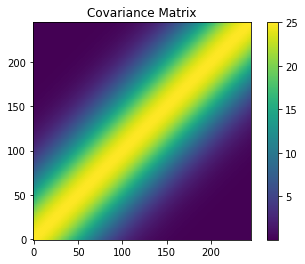

Histogram of K(Xtest, Xtest):


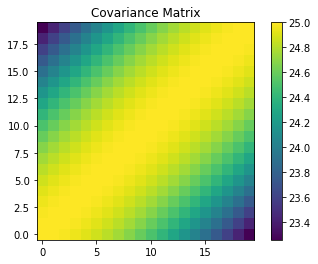

Histogram of K(Xtrain, Xtest):


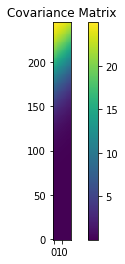

In [8]:
# visualizing the kernel matrix for first 20 values
# the concentration can be seen along diagonal values due to the properties of Squared Exponential Kernel
sigma_f = 5
l = 50

print("Histogram of K(Xtrain, Xtrain):")
kernel_visualize(Xtrain, Xtrain, l, sigma_f)

print("Histogram of K(Xtest, Xtest):")
kernel_visualize(Xtest, Xtest, l, sigma_f)

print("Histogram of K(Xtrain, Xtest):")
kernel_visualize(Xtrain, Xtest, l, sigma_f)


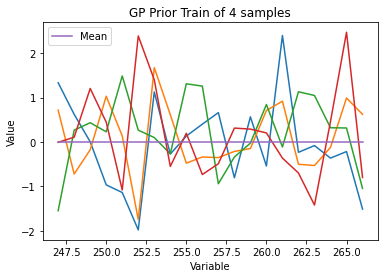

In [9]:
#visualize GP of  Finite number of points

Xplot = Xtest
numplot = len(Xplot)
Kplot = kernel(Xplot, Xplot, .1, 1)

rand_draw_prior = np.dot(Kplot, np.random.normal(size=(numplot, 4)))

figre, axs = plt.subplots()
variances = np.diag(Kplot) # diagonal elements are individual vairance
std_dev = np.sqrt(variances)

# plt.fill_between(Xplot.reshape(-1), 1.96 * std_dev,  - 1.96 * std_dev, alpha=0.1)

plt.plot(Xplot, rand_draw_prior)
plt.plot(Xplot, np.zeros(len(Xplot)), label='Mean')
plt.title("GP Prior Train of 4 samples")
plt.xlabel("Variable")
plt.ylabel("Value")
plt.legend()
plt.show()

In [10]:
def Cinv(K, sigma_y):
    K_inv = np.linalg.inv(K + (sigma_y*sigma_y)*np.eye(len(Xtrain)))
    return K_inv

def posterior_predictive(Xtrain, Ytrain, l, sigma_y, sigma_f, X):
    cov_s = 0.0
    K_ss = kernel(X, X, l, sigma_f)
    K_s = kernel(Xtrain, X, l, sigma_f)

    mu_s = 0.0
    K = kernel(Xtrain, Xtrain, l, sigma_f)
    K_inv = Cinv(K, sigma_y)
    
    sigma_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    mu_s = K_s.T.dot(K_inv).dot(Ytrain)
    
    return mu_s, sigma_s

In [11]:
def predict_and_plot(Xtrain, Ytrain, l, sigma_f, sigma_y, Xtest, Ytest): 
    mu, sigma = posterior_predictive(Xtrain, Ytrain, l, sigma_y, sigma_f, Xtest)

    figr, axs = plt.subplots()

    plt.plot(Xtrain, Ytrain, 'c')
    plt.plot(Xtest, Ytest, 'c--')
    plt.plot(Xtest, mu, 'g')
    plt.xlabel("Day Number")
    plt.ylabel("Number of Cases")
    plt.legend(["Training", "Test","Prediction"])
    plt.title("Data and Predictions : Big Picture")

    plt.show()
    
    if Xtrain.all() == Xtest.all():
        return mu, sigma

    plt.plot(Xtest, Ytest)
    plt.plot(Xtest, mu)
#     pred = np.array(mu)
#     pred = pred.T
#     sgma = np.array(sigma)
#     plt.errorbar(Xtest, pred, yerr = sgma, capsize = 0)
    plt.xlabel("Day Number")
    plt.ylabel("Number of Cases")
    plt.legend(["Test", "Prediction"])
    plt.title("Zoomed in View on Test set")
    plt.show()  
    
    plt.imshow(sigma, interpolation='none')
    plt.title("Covariance Matrix PPD")
    axs.set_ylim(axs.get_ylim()[::-1])
    plt.colorbar()
    plt.show()
    
    return mu, sigma

Fitting Train Data - India on Self-fed HyperParameters:


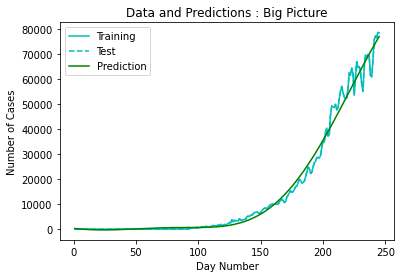

Predictions - India on Self-fed HyperParameters:


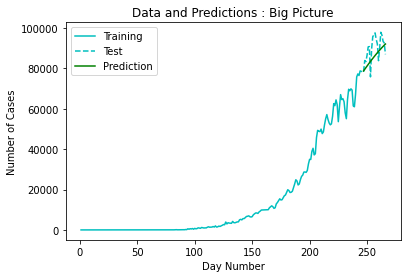

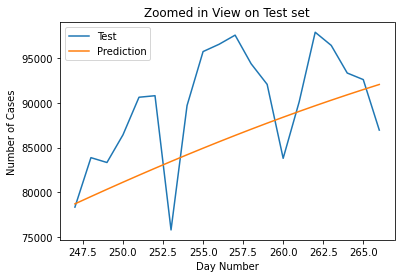

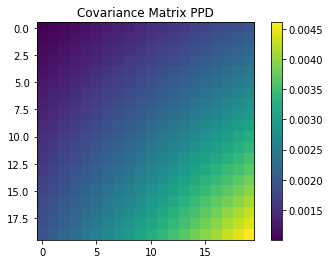

(India)Mean values of predictions with guessed hyperparams day 246 onwards:
 [78718.54608308445 79536.89037626106 80344.30785235805 81140.42041637501
 81924.85588665624 82697.24826844232 83457.23802125576 84204.47231995243
 84938.60530914333 85659.2983507689 86366.22026463997 87059.04756167314
 87737.46466965023 88401.16415132931 89049.84691469798 89683.22241516976
 90301.00884962128 90902.93334208518 91488.73212094257 92058.15068750392] 

Sigma:
 [[0.00100225 0.00104659 0.00109176 0.00113777 0.00118459 0.00123222
  0.00128064 0.00132984 0.0013798  0.00143052 0.00148196 0.00153412
  0.00158698 0.00164052 0.00169473 0.00174958 0.00180505 0.00186113
  0.00191779 0.00197501]
 [0.00104659 0.00109387 0.00114208 0.0011912  0.00124121 0.00129211
  0.00134388 0.0013965  0.00144997 0.00150426 0.00155936 0.00161525
  0.00167192 0.00172934 0.0017875  0.00184638 0.00190595 0.00196619
  0.00202708 0.00208861]
 [0.00109176 0.00114208 0.0011934  0.00124571 0.00129901 0.00135326
  0.00140848 0.0014646

In [12]:
# 100 1 
l= 95
sigma_f= .6
sigma_y=.1

print("Fitting Train Data - India on Self-fed HyperParameters:")
mu_india, sigma_india = predict_and_plot(Xtrain, Ytrain_India, l, sigma_f, sigma_y, Xtrain, Ytrain_India)                         


print("Predictions - India on Self-fed HyperParameters:")
mu_india, sigma_india = predict_and_plot(Xtrain, Ytrain_India, l, sigma_f, sigma_y, Xtest, Ytest_India)                         

# kernel_visualize()

print("(India)Mean values of predictions with guessed hyperparams day 246 onwards:\n", mu_india, "\n\nSigma:\n", sigma_india)

Fiited Train Data - World on Self-fed HyperParameters:


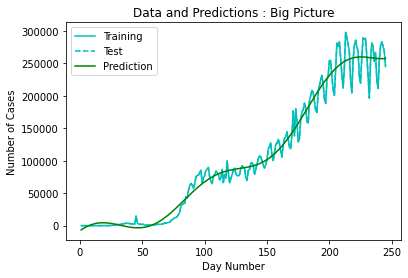

Predictions - World on Self-fed HyperParameters:


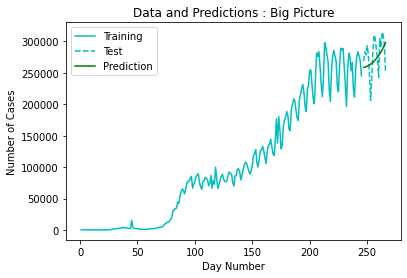

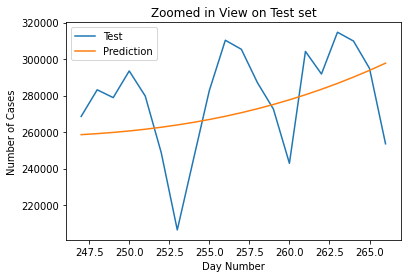

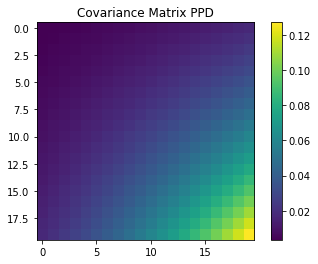

(World)Mean values of predictions with guessed hyperparams day 246 onwards:
 [258569.3014349877 259116.84568248683 259787.43255593628 260589.7210676662
 261532.25391014206 262623.4364164559 263871.51563897106
 265284.55988075514 266870.4384394374 268636.80185683933
 270591.06255369936 272740.3759437578 275091.6221648996 277651.388283049
 280425.9512256839 283421.26129858487 286642.9264371041 290096.1972038683
 293785.95253785833 297716.68629677285] 

Sigma:
 [[0.00346758 0.00389563 0.00435381 0.00484314 0.00536463 0.00591931
  0.00650815 0.00713214 0.00779221 0.0084893  0.00922431 0.00999812
  0.01081156 0.01166545 0.01256056 0.01349764 0.01447738 0.01550044
  0.01656743 0.01767892]
 [0.00389564 0.00439276 0.00492566 0.00549563 0.00610389 0.0067517
  0.00744027 0.00817079 0.00894444 0.00976237 0.01062569 0.0115355
  0.01249284 0.01349873 0.01455414 0.01566    0.01681719 0.01802654
  0.01928885 0.02060483]
 [0.00435381 0.00492566 0.0055395  0.00619685 0.00689922 0.0076481
  0.00844496 0

In [13]:
# 75 15
l= 75
sigma_f= 15
sigma_y=.1

print("Fiited Train Data - World on Self-fed HyperParameters:")
mu_world, sigma_world = predict_and_plot(Xtrain, Ytrain_World, l, sigma_f, sigma_y, Xtrain, Ytrain_World)                         

print("Predictions - World on Self-fed HyperParameters:")
mu_world, sigma_world = predict_and_plot(Xtrain, Ytrain_World, l, sigma_f, sigma_y, Xtest, Ytest_World)                         

print("(World)Mean values of predictions with guessed hyperparams day 246 onwards:\n", mu_world, "\n\nSigma:\n", sigma_world) 

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -3,093.7, ||grad|| = 1.8695: 100%|██████████| 34/34 [00:00<00:00, 152.11it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma]
100%|██████████| 1500/1500 [00:15<00:00, 94.75it/s]
There were 507 divergences after tuning. Increase `target_accept` or reparameterize.
There were 822 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some p

<MultiTrace: 2 chains, 1000 iterations, 2 variables> 

<class 'pymc3.model.FreeRV'>


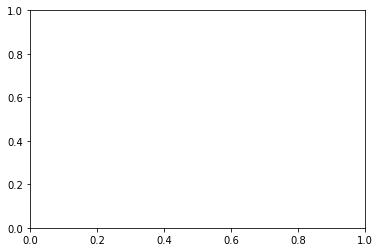

In [28]:
# A one dimensional column vector of inputs for the input train vector
X = np.linspace(0,244,245)[:,None]

# copy train data to the array y
y = [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,1 ,0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,2 ,1 ,22 ,1 ,2 ,3 ,0 ,10 ,6 ,23 ,2 ,8 ,7 ,3 ,32 ,12 ,28 ,26 ,40 ,89 ,119 ,53 ,70 ,87 ,75 ,149 ,106 ,92 ,180 ,146 ,568 ,336 ,601 ,472 ,693 ,354 ,773 ,540 ,678 ,1035 ,909 ,796 ,1211 ,1075 ,942 ,1007 ,991 ,1334 ,1553 ,1335 ,1384 ,1409 ,1684 ,1429 ,1990 ,1396 ,1543 ,1897 ,1718 ,1993 ,2293 ,2644 ,2553 ,3900 ,2958 ,3561 ,3390 ,3320 ,3277 ,4213 ,3604 ,3525 ,3722 ,3967 ,3970 ,4987 ,5242 ,4970 ,5611 ,5609 ,6088 ,6654 ,6767 ,6977 ,6535 ,6387 ,6566 ,7466 ,7964 ,8380 ,8392 ,8171 ,8909 ,9304 ,9851 ,9887 ,9971 ,9983 ,9987 ,9985 ,9996 ,10956 ,11458 ,11929 ,11502 ,10667 ,10974 ,12881 ,13586 ,14516 ,15413 ,14821 ,14933 ,15968 ,16922 ,17296 ,18552 ,19906 ,19459 ,18522 ,18653 ,19148 ,20903 ,22771 ,24850 ,24248 ,22252 ,22752 ,24879 ,26506 ,27114 ,28637 ,28701 ,28498 ,29429 ,32695 ,34956 ,34884 ,38902 ,40425 ,37148 ,37724 ,45720 ,49310 ,48916 ,48661 ,49931 ,47703 ,48513 ,52123 ,55078 ,57118 ,54735 ,52972 ,52050 ,52509 ,56282 ,62538 ,61537 ,64399 ,62064 ,53601 ,60963 ,66999 ,64553 ,65002 ,63490 ,57981 ,55079 ,64531 ,69652 ,68898 ,69878 ,69239 ,61408 ,60975 ,67151 ,75760 ,77266 ,76472 ,78761 ,78512]

mn = Ytrain_India[244]
# A smaller set of inducing inputs
Xu = np.linspace(130,200,70)[:,None]

with pm.Model() as model:
    # Specify the covariance function.
    # using  
    #The Exponentiated Quadratic kernel.  Also refered to as the Squared
    #Exponential, or Radial Basis Function kernel.
    #.. math::
    #   k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right]

    #ls: Lengthscale.  If input_dim > 1, a list or array of scalars or PyMC3 random
    #variables.  If input_dim == 1, a scalar or PyMC3 random variable.
    cov_func = pm.gp.cov.ExpQuad(1, ls=1)

    figre, axs = plt.subplots()

    mean_func = pm.gp.mean.Constant(mn)

    gp = pm.gp.MarginalSparse(mean_func = mean_func, cov_func=cov_func, approx="FITC")

    # Place a GP prior over the function f.
    sigma = pm.HalfCauchy("sigma", beta=3)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y, noise=sigma)
    
    mp = pm.find_MAP()
    trace = pm.sample(1000)
    print(trace, "\n")

...

# After fitting or sampling, specify the distribution
# at new points with .conditional
Xnew = np.linspace(245, 265, 20)[:, None]

with model:
    fcond = gp.conditional("fcond", Xnew=Xnew)
    print(type(fcond))


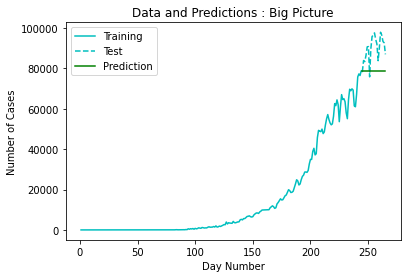

In [34]:
Xs = np.linspace(245, 265, 20)[:, None]
with model:
    samples = gp.predict(Xs, point=trace[-1], diag=False, pred_noise=0.1, given=None)# (trace, gp, Xs, n_samples=20, obs_noise=False)

figr, axs = plt.subplots()

plt.plot(Xtrain, Ytrain_India, 'c')
plt.plot(Xs, Ytest_India, 'c--')
plt.plot(Xs, samples[0], 'g')
plt.xlabel("Day Number")
plt.ylabel("Number of Cases")
plt.legend(["Training", "Test","Prediction"])
plt.title("Data and Predictions : Big Picture")

plt.show()

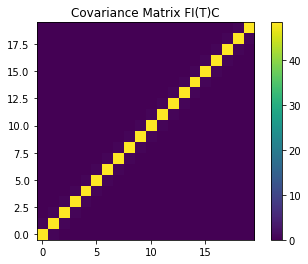

In [35]:
figre, axs = plt.subplots()
plt.imshow(samples[1], interpolation='none')
plt.title("Covariance Matrix FI(T)C")
axs.set_ylim(axs.get_ylim()[::-1])
plt.colorbar()
plt.show()

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -3,355.7, ||grad|| = 172.71: 100%|██████████| 37/37 [00:00<00:00, 144.30it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma]
100%|██████████| 1500/1500 [00:17<00:00, 86.73it/s]
There were 467 divergences after tuning. Increase `target_accept` or reparameterize.
There were 740 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some p

<MultiTrace: 2 chains, 1000 iterations, 2 variables> 

<class 'pymc3.model.FreeRV'>


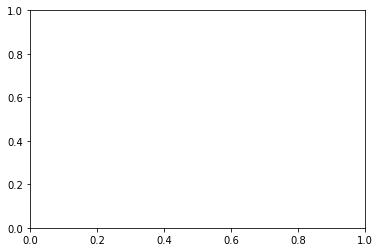

In [36]:
# A one dimensional column vector of inputs for the input train vector
X = np.linspace(0,244,245)[:,None]

# copy train data to the array y
y = [27 ,0 ,0 ,17 ,0 ,15 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,0 ,1 ,0 ,5 ,17 ,136 ,20 ,153 ,142 ,97 ,266 ,453 ,673 ,797 ,1767 ,1480 ,1756 ,2001 ,2122 ,2608 ,2818 ,3243 ,3908 ,3751 ,3218 ,3442 ,2618 ,2992 ,2562 ,2072 ,15151 ,4215 ,2560 ,2162 ,2067 ,1995 ,1864 ,532 ,996 ,1085 ,1009 ,523 ,793 ,867 ,1114 ,1266 ,1859 ,1826 ,2087 ,1857 ,2312 ,2354 ,3058 ,4120 ,3977 ,4177 ,4816 ,5107 ,7898 ,9451 ,10404 ,12165 ,12455 ,14201 ,17006 ,20214 ,31094 ,31909 ,34207 ,34357 ,44415 ,42386 ,53750 ,61016 ,65094 ,62814 ,57363 ,64488 ,74674 ,77473 ,77458 ,81830 ,85243 ,66276 ,72988 ,77267 ,84920 ,87264 ,89512 ,75314 ,68528 ,64720 ,76496 ,78348 ,83941 ,81779 ,79563 ,70562 ,73735 ,86665 ,66344 ,78485 ,72792 ,99782 ,81677 ,65820 ,72254 ,78802 ,85333 ,88667 ,80628 ,77165 ,76536 ,78683 ,87557 ,92424 ,89211 ,88843 ,74694 ,69734 ,86213 ,86257 ,96543 ,97219 ,92935 ,79503 ,86367 ,95544 ,103327 ,107780 ,105800 ,100027 ,93155 ,88843 ,93781 ,102819 ,118506 ,122069 ,127938 ,106716 ,100294 ,112387 ,125512 ,126924 ,133190 ,125997 ,114829 ,105621 ,125237 ,134854 ,136155 ,144626 ,133412 ,121196 ,118495 ,141476 ,176864 ,138450 ,180311 ,160317 ,129198 ,134239 ,163892 ,174994 ,178741 ,188672 ,182028 ,160203 ,158158 ,192085 ,200376 ,208625 ,205524 ,191064 ,178279 ,174279 ,206942 ,215506 ,225147 ,231461 ,217994 ,195499 ,188446 ,223693 ,231699 ,254378 ,254427 ,230166 ,209441 ,200764 ,239785 ,281633 ,276291 ,283911 ,259628 ,231858 ,211907 ,243802 ,298111 ,290431 ,279062 ,267857 ,223292 ,204657 ,255672 ,277604 ,285925 ,275903 ,268718 ,229414 ,219766 ,261467 ,289348 ,286670 ,288918 ,259633 ,232361 ,196546 ,255024 ,281518 ,276318 ,253231 ,266730 ,224348 ,211458 ,255073 ,276675 ,283410 ,276599 ,269011 ,245224]

mn = y[244]+10000
# A smaller set of inducing inputs
Xu = np.linspace(130,200,70)[:,None]

with pm.Model() as model:
    # Specify the covariance function.
    # using  
    #The Exponentiated Quadratic kernel.  Also refered to as the Squared
    #Exponential, or Radial Basis Function kernel.
    #.. math::
    #   k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right]

    #ls: Lengthscale.  If input_dim > 1, a list or array of scalars or PyMC3 random
    #variables.  If input_dim == 1, a scalar or PyMC3 random variable.
    cov_func = pm.gp.cov.ExpQuad(1, ls=1)

    figre, axs = plt.subplots()

    mean_func = pm.gp.mean.Constant(mn)

    gp = pm.gp.MarginalSparse(mean_func = mean_func, cov_func=cov_func, approx="FITC")

    # Place a GP prior over the function f.
    sigma = pm.HalfCauchy("sigma", beta=3)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y, noise=sigma)
    
    mp = pm.find_MAP()
    trace = pm.sample(1000)
    print(trace, "\n")

...

# After fitting or sampling, specify the distribution
# at new points with .conditional
Xnew = np.linspace(245, 265, 20)[:, None]

with model:
    fcond = gp.conditional("fcond", Xnew=Xnew)
    print(type(fcond))


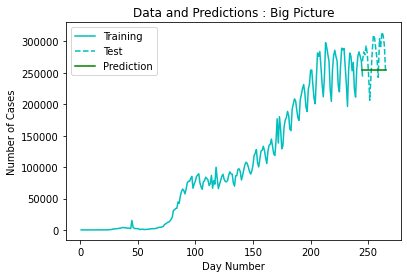

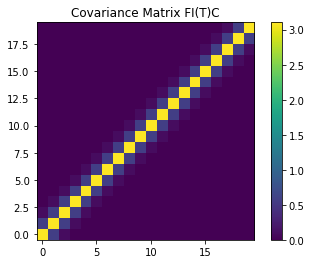

In [38]:
Xs = np.linspace(245, 265, 20)[:, None]
with model:
    samples = gp.predict(Xs, point=trace[-1], diag=False, pred_noise=0.1, given=None)# (trace, gp, Xs, n_samples=20, obs_noise=False)

figr, axs = plt.subplots()

plt.plot(Xtrain, Ytrain_World, 'c')
plt.plot(Xs, Ytest_World, 'c--')
plt.plot(Xs, samples[0], 'g')
plt.xlabel("Day Number")
plt.ylabel("Number of Cases")
plt.legend(["Training", "Test","Prediction"])
plt.title("Data and Predictions : Big Picture")

plt.show()

figre, axs = plt.subplots()
plt.imshow(samples[1], interpolation='none')
plt.title("Covariance Matrix FI(T)C")
axs.set_ylim(axs.get_ylim()[::-1])
plt.colorbar()
plt.show()